In [1]:
from google.colab import drive
drive.mount('/drive/')

Mounted at /drive/


In [2]:

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.1


In [3]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:21tcmalloc: large alloc 1147494400 bytes == 0x38c94000 @  0x7f8adb427615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.1 MB/s eta 0:01:29tcmalloc: large alloc 1434370048 bytes == 0x7d2ea000 @  0x7f8adb427615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

# load CLIP model

In [4]:
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lqwhvvh4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-lqwhvvh4
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=d6952bf58d8bfc3c861ad61f0be0e8313b65eab0a84805fc92b5d20b3b7a155d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q5kw8iik/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [5]:
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm
import time

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu110


In [6]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [67]:
model, preprocess = clip.load("RN50")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 170MiB/s]


In [8]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f3dd2963c20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## add Normalize layer

In [9]:
class NormalizeLayer(torch.nn.Module):
    def __init__(self, means, sds):
        """
        :param means: the channel means
        :param sds: the channel standard deviations
        """
        super(NormalizeLayer, self).__init__()
        self.means = torch.tensor(means).cuda()
        self.sds = torch.tensor(sds).cuda()

    def forward(self, input: torch.tensor):
        (batch_size, num_channels, height, width) = input.shape
        means = self.means.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2)
        sds = self.sds.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2)
        input_norm=(input - means) / sds
        return input_norm


def get_normalize_layer(dataset: str) -> torch.nn.Module:
    """Return the dataset's normalization layer"""
    _IMAGENET_MEAN = [0.48145466, 0.4578275, 0.40821073]
    _IMAGENET_STDDEV = [0.26862954, 0.26130258, 0.27577711]

    if dataset == "imagenet":
        return NormalizeLayer(_IMAGENET_MEAN, _IMAGENET_STDDEV)


In [10]:
# normalize
dataset='imagenet'
normalize_layer = get_normalize_layer(dataset)

# Load ImageNet dataset

In [11]:
#@title
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]

In [12]:
#@title
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

print(f"{len(imagenet_classes)} classes, {len(imagenet_templates)} templates")

1000 classes, 80 templates


In [13]:
! pip install git+https://github.com/modestyachts/ImageNetV2_pytorch
 
from imagenetv2_pytorch import ImageNetV2Dataset
from torchvision import transforms
import PIL
from PIL import Image
import torch.nn.functional as F

batchSize=10

# test_dataset = ImageNetV2Dataset(transform=preprocess)

preprocess_size=224

transformer = transforms.Compose([
        transforms.Resize(size=preprocess_size, interpolation=PIL.Image.BICUBIC),
        transforms.CenterCrop(size=(preprocess_size, preprocess_size)),
        transforms.ToTensor()
    ])
test_dataset = ImageNetV2Dataset(transform=transformer)

loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, num_workers=1,shuffle=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/modestyachts/ImageNetV2_pytorch to /tmp/pip-req-build-e7ez5787
  Running command git clone -q https://github.com/modestyachts/ImageNetV2_pytorch /tmp/pip-req-build-e7ez5787
  Created wheel for imagenetv2-pytorch: filename=imagenetv2_pytorch-0.1-py3-none-any.whl size=2664 sha256=80165eb11f28d1b9912489daea51ec39d546e46560f80dad44adae900dd36bc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdb0cfu9/wheels/ab/ee/f4/73bce5c7f68d28ce632ef33ae87ce60aaca021eb2b3b31a6fa
Successfully built imagenetv2-pytorch
Dataset matched-frequency not found on disk, downloading....


100%|██████████| 1.26G/1.26G [00:46<00:00, 27.2MiB/s]


Extracting....


## Creating zero-shot classifier weights

In [14]:
def zeroshot_classifier(model, classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier(model,imagenet_classes, imagenet_templates)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
def label_zeroshot_classifier(model, classnames):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            # texts = [template.format(classname) for template in templates] #format with class
            texts = classname
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

label_zeroshot_weights = label_zeroshot_classifier(model,imagenet_classes)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Plot and save image

In [16]:
import torchvision
import matplotlib.pyplot as plt
def imshow(img, title, normalized=False):
    if normalized==True:
      image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
      image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
      img *= image_std[:, None, None]
      img += image_mean[:, None, None]
    
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.axis('off')
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [17]:
def save_img(img, path, normalized=False):
  if normalized==True:
      image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
      image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
      img *= image_std[:, None, None]
      img += image_mean[:, None, None]
      
  torchvision.utils.save_image(img,path)


In [18]:
# imshow(torchvision.utils.make_grid(total_adv_images[0].cpu().data, normalize=False), ["adv image"])

# Generate MRI/LRI

In [43]:
def loss_func(model, x, zeroshot_weights=None, labels_weights=None, target_clip=None, positive_weights=None, scenario=0):
    predict_clip = model.encode_image(normalize_layer(x.cuda()))
    predict_clip_n = predict_clip / predict_clip.norm(dim=-1, keepdim=True)



    if scenario == 1: #MRI
        # close to most of class

        logits = 100. * predict_clip_n @ zeroshot_weights
        loss_others_min_all, _ = torch.min(logits, dim=1)
        loss_others_min = loss_others_min_all.sum()
  
        alpha = 1.0
        loss_all = alpha * (100 - loss_others_min_all)
        # loss_all = alpha * loss_others_min_all
        # loss_all =-alpha*loss_others_min_all + (1-alpha)*loss_label_all + 15
        loss = loss_all.sum()

        return loss, loss_others_min,  loss_all, loss_others_min_all
    
    elif scenario == 2: #LRI
        # close to specific class, far away from any classes

        target_logits = 100. * torch.cosine_similarity(predict_clip, target_clip, dim=-1)
        loss_target_all = target_logits
        loss_target = loss_target_all.sum()

        logits = 100. * predict_clip_n @ zeroshot_weights
        loss_others_max, _ = torch.max(logits, dim=1)
        loss_others_max_all = loss_others_max
        loss_others_max = loss_others_max_all.sum()

        alpha = 0.5

        act_relu = torch.nn.ReLU()
        loss_all = alpha * (100 - loss_target_all) + (1 - alpha) * act_relu(loss_others_max_all) 
        loss = loss_all.sum()


        return loss, loss_target, loss_others_max, loss_all, loss_target_all, loss_others_max_all

       

    # print('loss_target: %.2f, loss_cw: %.2f, loss_others: %.2f, total_loss: %.2f'%(loss_target.detach().cpu().numpy(),loss_cw.detach().cpu().numpy(),loss_others.detach().cpu().numpy(),loss.detach().cpu().numpy()))
    # print("pred_target_logits:",-target_logits.detach().cpu().numpy())
    # print("other_logits_max_all:",loss_others_max_all.detach().cpu().numpy())

    # print('loss_target: %.2f, loss_cw: %.2f, loss_others_min: %.2f, total_loss: %.2f'%(loss_target.detach().cpu().numpy(),loss_cw.detach().cpu().numpy(),loss_others_min.detach().cpu().numpy(),loss.detach().cpu().numpy()))
    # print("pred_target_logits:",-target_logits.detach().cpu().numpy())
    # print("label_logits:",loss_label_all.detach().cpu().numpy())
    # print("others_logits_min_all:",loss_others_min_all.detach().cpu().numpy())


In [20]:
def check_oscillation(x, j, k, y5, k3=0.5):
    # count how many cases since the last point successfully reduce f 
    t = np.zeros(x.shape[1])
    for counter5 in range(k):
      t += x[j - counter5] > x[j - counter5 - 1]
      # t += x[j - counter5] < x[j - counter5 - 1]
    
    # print("---t:(larger t is better)",t)
    # print("---k*k3=",k*k3)
    return t <= k*k3*np.ones(t.shape)

In [21]:
# https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/torchattacks/attacks/apgdt.py
def apgd_perturb(model, x, y, eps=0.03, device='cuda', norm='Linf', n_iter=100, thr_decr=0.75,
            delta=0.01,scenario=0,positive_weights=None,labels_weights=None,target_clip=None,zeroshot_weights=None):
    
    print("auto pgd attack")
    eot_iter = 1
    # # VIT model
    # threshold_u = 30
    # threshold_l = 25

    # RN50-x4 model
    threshold_u = 50
    threshold_l = 10

    margin = 10

    n_iter_2 = max(int(0.22 * n_iter), 1)  # initial 0.22, try 0.11/0.33
    n_iter_min = max(int(0.06 * n_iter), 1)
    size_decr = max(int(0.03 * n_iter), 1)
    print('Parameters: n_iter:%d, n_iter_2:%d, n_iter_min:%d, size_decr:%d, eot_iter:%d ' % (
    n_iter, n_iter_2, n_iter_min, size_decr, eot_iter))


    if  norm== 'Linf':
        t = 2 * torch.rand(x.shape).to(device).detach() - 1
        x_adv = x.detach() + eps * torch.ones([x.shape[0], 1, 1, 1]).to(device).detach() * t / (
            t.reshape([t.shape[0], -1]).abs().max(dim=1, keepdim=True)[0].reshape([-1, 1, 1, 1]))
    elif norm == 'L2':
        t = torch.randn(x.shape).to(device).detach()
        x_adv = x.detach() + eps * torch.ones([x.shape[0], 1, 1, 1]).to(device).detach() * t / (
                    (t ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12)

    x_min = x.min().item()
    x_max = x.max().item()
    print(x_min, x_max)
    x_adv = x_adv.clamp(x_min, x_max)

    # x_adv = x_adv.clamp(0., 1.)
    x_best = x_adv.clone()
    x_best_adv = x_adv.clone()

    loss_steps = torch.zeros([n_iter, x.shape[0]])
    loss_best_steps = torch.zeros([n_iter + 1, x.shape[0]])
    acc_steps = torch.zeros_like(loss_best_steps)

    x_adv.requires_grad_()
    grad = torch.zeros_like(x)
    for _ in range(eot_iter):
        with torch.enable_grad():
            # loss_indiv,loss,loss_pred_all,target_logits=pgd_loss(model,x_adv,target_clip)
            if scenario==1:
              loss, loss_pos, loss_indiv, loss_pos_all = loss_func(model,
                                                                  x_adv,
                                                                  zeroshot_weights,
                                                                  labels_weights,
                                                                  target_clip,
                                                                  positive_weights,scenario=scenario)
            else:
              loss, loss_pos, loss_neg, loss_indiv, loss_pos_all, loss_neg_all = loss_func(model,
                                                                                          x_adv,
                                                                                          zeroshot_weights,
                                                                                          labels_weights,
                                                                                          target_clip,
                                                                                          positive_weights,scenario=scenario)
            # loss,loss_label,loss_cw,loss_others_min,loss_all,loss_label_all,loss_cw_all,loss_others_min_all=loss_func(model,x_adv,labels_weights,target_clip)

        grad += torch.autograd.grad(loss, [x_adv])[0].detach()  # 1 backward pass (eot_iter = 1)

    grad /= float(eot_iter)
    grad_best = grad.clone()

    # acc = (-target_logits >= threshold_u)
    
    if scenario==3  or scenario==1 :
        acc = (loss_pos_all >= threshold_u)
    else:
        correct = (loss_pos_all >= threshold_u)
        correct1 = (loss_neg_all <= threshold_l)
        acc = torch.logical_and(correct, correct1)

    # acc =(loss_pos_all-loss_neg_all >=margin)

    acc_steps[0] = acc + 0
    loss_best = loss_indiv.detach().clone()

    step_size = eps * torch.ones([x.shape[0], 1, 1, 1]).to(device).detach() * torch.Tensor([0.5]).to(
        device).detach().reshape([1, 1, 1, 1])  # initial *2
    x_adv_old = x_adv.clone()
    counter = 0
    k = n_iter_2 + 0
    u = np.arange(x.shape[0])
    counter3 = 0

    loss_best_last_check = loss_best.clone()
    reduced_last_check = np.zeros(loss_best.shape) == np.zeros(loss_best.shape)
    n_reduced = 0

    loss_history = []

    for i in range(n_iter):
        ### gradient step
        with torch.no_grad():
            x_adv = x_adv.detach()
            grad2 = x_adv - x_adv_old
            x_adv_old = x_adv.clone()

            a = 0.75 if i > 0 else 1.0

            if norm == 'Linf':
                # need to *(-1), if want to decrease the loss
                x_adv_1 = x_adv + (-1) * step_size * torch.sign(grad)
                x_adv_1 = torch.clamp(torch.min(torch.max(x_adv_1, x - eps), x + eps), x_min, x_max)
                x_adv_1 = torch.clamp(
                    torch.min(torch.max(x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a), x - eps), x + eps), x_min,
                    x_max)

            elif norm == 'L2':
                x_adv_1 = x_adv + step_size[0] * grad / (
                            (grad ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12)
                x_adv_1 = torch.clamp(x + (x_adv_1 - x) / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12) * torch.min(
                    eps * torch.ones(x.shape).to(device).detach(),
                    ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()), x_min, x_max)
                x_adv_1 = x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a)
                x_adv_1 = torch.clamp(x + (x_adv_1 - x) / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12) * torch.min(
                    eps * torch.ones(x.shape).to(device).detach(),
                    ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12), x_min, x_max)

            x_adv = x_adv_1 + 0.

        # get gradient
        x_adv.requires_grad_()
        grad = torch.zeros_like(x)
        for _ in range(eot_iter):
            with torch.enable_grad():
                if scenario==1 :
                    loss, loss_pos, loss_indiv, loss_pos_all = loss_func(model,
                                                                        x_adv,
                                                                        zeroshot_weights,
                                                                        labels_weights,
                                                                        target_clip,
                                                                        positive_weights,scenario=scenario)
                else:
                  loss, loss_pos, loss_neg, loss_indiv, loss_pos_all, loss_neg_all = loss_func(model,
                                                                                              x_adv,
                                                                                              zeroshot_weights,
                                                                                              labels_weights,
                                                                                              target_clip,
                                                                                              positive_weights,scenario=scenario)

            grad += torch.autograd.grad(loss, [x_adv])[0].detach()  # 1 backward pass (eot_iter = 1)

        grad /= float(eot_iter)
        loss_history.append(loss_indiv)



        if scenario ==1 :
          correct = (loss_pos_all >= threshold_u)
          succ=correct

        else:
          correct = (loss_pos_all >= threshold_u)
          correct1 = (loss_neg_all <= threshold_l)
          succ = torch.logical_and(correct, correct1)


        acc = torch.max(succ, acc)
        success_rate = acc.sum() / len(acc)

        acc_steps[i + 1] = acc + 0
        if (correct == 1).nonzero().squeeze().numel():
            # print('-----update x_best_adv-----')
            # print((correct == 1).nonzero().squeeze())
            x_best_adv[(correct == 1).nonzero().squeeze()] = x_adv[(correct == 1).nonzero().squeeze()] + 0.

        

              


        # check step size
        with torch.no_grad():
            y1 = loss_indiv.detach().clone()
            loss_steps[i] = y1.cpu() + 0

            # ind = (y1 > loss_best).nonzero().squeeze()
            # if decrease loss
            ind = (y1 < loss_best).nonzero().squeeze()
            x_best[ind] = x_adv[ind].clone()
            grad_best[ind] = grad[ind].clone()
            
            loss_best[ind] = y1[ind] + 0
            loss_best_steps[i + 1] = loss_best + 0


            counter3 += 1

            if counter3 == k:
                # print(">>>>>>>loss_steps:",loss_steps)
                # print(">>>>>loss_best_last_check:",loss_best_last_check.cpu().numpy())
                # print(">>>>>loss_best:",loss_best.cpu().numpy())
                fl_oscillation = check_oscillation(loss_steps.detach().cpu().numpy(), i, k,
                                                    loss_best.detach().cpu().numpy(), k3=thr_decr)

                # fl_reduce_no_impr = (~reduced_last_check) * (loss_best_last_check.cpu().numpy() >= loss_best.cpu().numpy())
                #if decrease loss
                fl_reduce_no_impr = (~reduced_last_check) * (loss_best_last_check.cpu().numpy() <= loss_best.cpu().numpy())
                
                # print(fl_oscillation)
                # print(fl_reduce_no_impr)

                # if two condition: 1. oscillation 2. loss not improve
                fl_oscillation = ~(~fl_oscillation * ~fl_reduce_no_impr)
                reduced_last_check = np.copy(fl_oscillation)
                loss_best_last_check = loss_best.clone()
                # print(fl_oscillation)

                if np.sum(fl_oscillation) > 0:
                    step_size[u[fl_oscillation]] /= 2.0
                    n_reduced = fl_oscillation.astype(float).sum()

                    fl_oscillation = np.where(fl_oscillation)
                    # restart from the best x
                    x_adv[fl_oscillation] = x_best[fl_oscillation].clone()
                    grad[fl_oscillation] = grad_best[fl_oscillation].clone()

                counter3 = 0
                k = np.maximum(k - size_decr, n_iter_min)
                # print(">>>>>>adjust step size:",step_size)
                # print(">>>>>>k:",k)
                # print(">>>>>>size_decr:",size_decr)

        if i % 10 == 0:
            print("-----------------------------")
            
            print('iteration: {} - Best loss: {:.6f} - Success Rate: {:.2f}'.format(i, loss_best.sum(), success_rate))
            if scenario ==1:
              print('loss_positive: %.2f, total_loss: %.2f' % (
              loss_pos.detach().cpu().numpy(), loss.detach().cpu().numpy()))
            else:
              print('loss_positive: %.2f, loss_negative: %.2f, total_loss: %.2f' % (
              loss_pos.detach().cpu().numpy(), loss_neg.detach().cpu().numpy(),
              loss.detach().cpu().numpy()))
              print("loss_neg_all:", loss_neg_all.detach().cpu().numpy())
              
            print("loss_pos_all:", loss_pos_all.detach().cpu().numpy())

    return x_best, acc, loss_best, x_best_adv, loss_history


In [24]:
 # generate AE
total_initial_image_features=[]
total_adv_image_features = []
total_labels = []
total_images = []
total_adv_images = []  
total_initial_logits=[]
total_adv_logits= []
total_select_pos= []
total_adv_target_logits=[]

eps = 8/255  # default 8 / 255 =0.03 

n_iter =101 # default 100
scenario=2 # 1:MRI, 2:LRI
norm='Linf'

 
# from IPython.core.debugger import set_trace
with torch.no_grad():
    # robust_flags = torch.zeros(10000, dtype=torch.bool, device='cuda')
    for batch_idx, (images, target) in enumerate(loader):
        if batch_idx>=1:
            break
        else:
            start_idx = batch_idx * batchSize
            end_idx = min((batch_idx + 1) * batchSize, 10000)
            images = images.cuda()
            target = target.cuda()
            total_images.append(images)

            labels = target
            print('labels:', labels)
            total_labels.append(labels)

            # predict
            image_features = model.encode_image(normalize_layer(images))
            image_features_n = image_features / image_features.norm(dim=-1, keepdim=True)

            initial_logits = 100. * image_features_n @ zeroshot_weights
            total_initial_logits.append(initial_logits)
            total_initial_image_features.append(image_features)

            logits,pred = initial_logits.topk(1, 1, True, True)
            print('initial logits:',logits.t())
            print('initial prediction:',pred.t())
            


            if scenario==1:# MRI
                # select number of close classes text descriptions
                num_pos = 10
                select_pos = np.random.choice(len(imagenet_classes), num_pos, replace=False) #imagenet_classes
                select_classes=[]
                for id in select_pos:
                  select_classes.append(imagenet_classes[id]) 
                print('-----------------------------------')
                select_classes=np.array(select_classes)
                print('select texts:', select_classes)
                total_select_pos.append(select_pos)

                positive_weights = zeroshot_classifier(model,select_classes, imagenet_templates)

                # run attack
                start = time.time()
                # use zeroshot_weights=positive_weights/zeroshot_weights
                best_curr, acc_curr, loss_curr, adv_curr, loss_history = apgd_perturb(model, images, target,
                                                                                       eps=eps, n_iter=n_iter,
                                                                                       scenario=1,
                                                                                       zeroshot_weights=positive_weights)  



                end = time.time()
                print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
                print("Time needed for AE generation: {}".format(end - start))

                adv_images = best_curr.clone().to('cuda')

                # evaluate adv
                adv_image_features = model.encode_image(normalize_layer(adv_images))
                adv_image_features_n = adv_image_features / adv_image_features.norm(dim=-1, keepdim=True)
                adv_logits = 100. * adv_image_features_n @ zeroshot_weights

                total_adv_images.append(adv_images)
                total_adv_image_features.append(adv_image_features)
                total_adv_logits.append(adv_logits)


                adv_logits_selected = 100. * adv_image_features_n @ positive_weights
                print('adv logits selected:', adv_logits_selected)
                adv_pred_selected=adv_logits_selected.topk(10, 1, False, True)[0]
                print('adv logits smallest 10:', adv_pred_selected)


            elif scenario==2: #LRI
                # close to specific class, far away from any classes
                code = 'nike'  
                text_descriptions=code
                # text_descriptions = [f"This is a photo of a {code}"]
                print(text_descriptions)
                tx = clip.tokenize(text_descriptions)
                with torch.no_grad():
                  target_clip  = model.encode_text(tx.cuda())
                
                # target_weights = zeroshot_classifier(model,[code], imagenet_templates)


                target_logits = 100. * torch.cosine_similarity(image_features, target_clip, dim=-1)
                print('Initial target logits:', target_logits)

                # run attack
                start = time.time()
                best_curr, acc_curr, loss_curr, adv_curr, loss_history = apgd_perturb(model, images, target,
                                                                                       eps=eps, n_iter=n_iter,norm=norm,
                                                                                       scenario=2,
                                                                                       target_clip=target_clip,
                                                                                       zeroshot_weights=label_zeroshot_weights)  

                end = time.time()
                print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
                print("Time needed for AE generation: {}".format(end - start))


                adv_images = best_curr.clone().to('cuda')

                # evaluate adv
                adv_image_features = model.encode_image(normalize_layer(adv_images))
                adv_image_features_n = adv_image_features / adv_image_features.norm(dim=-1, keepdim=True)
                adv_logits = 100. * adv_image_features_n @ zeroshot_weights
                

                adv_target_logits = 100. * torch.cosine_similarity(adv_image_features, target_clip, dim=-1)
                print('Adversarial target logits:', adv_target_logits)


                total_adv_images.append(adv_images)
                total_adv_image_features.append(adv_image_features)
                total_adv_logits.append(adv_logits)
                total_adv_target_logits.append(adv_target_logits)




labels: tensor([681, 506, 902, 795, 469,  15, 421, 307, 475, 178], device='cuda:0')
initial logits: tensor([[20.7344, 25.5938, 22.1562, 19.2344, 26.3281, 29.6562, 25.3906, 23.8906,
         25.5000, 24.9531]], device='cuda:0', dtype=torch.float16)
initial prediction: tensor([[652, 506, 767, 795, 469,  15, 687, 310, 475, 212]], device='cuda:0')
nike
Initial target logits: tensor([ 9.5859, 12.2422, 15.1016,  9.5234,  9.1172, 13.8438, 13.0469,  9.6953,
        12.2500, 10.8672], device='cuda:0', dtype=torch.float16)
auto pgd attack
Parameters: n_iter:101, n_iter_2:22, n_iter_min:6, size_decr:3, eot_iter:1 
0.0 1.0
-----------------------------
iteration: 0 - Best loss: 539.000000 - Success Rate: 0.00
loss_positive: 131.25, loss_negative: 209.00, total_loss: 539.00
loss_neg_all: [18.6  23.3  20.72 16.97 21.14 22.3  19.88 22.27 22.36 21.45]
loss_pos_all: [13.33 13.85 14.21 11.4  13.89 13.02 10.7  14.26 12.59 13.95]
-----------------------------
iteration: 10 - Best loss: 476.750000 - Succes

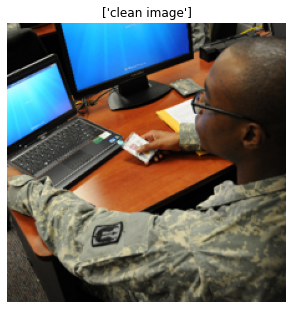

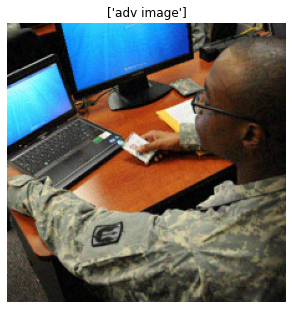

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


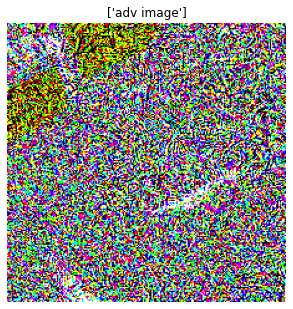

In [25]:
imshow(torchvision.utils.make_grid(total_images[0][0].cpu().data, normalize=False), ["clean image"])
imshow(torchvision.utils.make_grid(total_adv_images[0][0].cpu().data, normalize=False), ["adv image"])
imshow(torchvision.utils.make_grid(255*(total_adv_images[0][0]-total_images[0][0]).cpu().data, normalize=False), ["adv image"])
# imshow(torchvision.utils.make_grid(total_images[0].cpu().data, normalize=False), ["clean image"])

In [ ]:
save_img(total_images[0].cpu().cpu(),'/drive/My Drive/CLIP_project/1our_clean_779.jpg')

In [ ]:
save_img(total_adv_images[0].cpu().cpu(),'/drive/My Drive/CLIP_project/our_MRI_779.jpg')

# Search image by text, evaluate clean dataset R@k

In [ ]:
# import pandas as pd
# img_path = pd.read_csv("/drive/My Drive/CLIP_project/Imagenet/captions.csv")

# import os
# index=1
# plot_image('/drive/My Drive/CLIP_project/Imagenet/ImageNetV2-matched-frequency/'+ os.path.join(str(img_path.loc[index,'label']), img_path.loc[index,'image']))

# # plot_image('/drive/My Drive/CLIP_project/Imagenet/ImageNetV2-matched-frequency/400/8de0ee19611458b7f0b9e25447c9d5cd078959f8.jpeg')

In [53]:
def find_best_matches(model, text_features, photo_features, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = 100*(photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score
  best_photo_idx = (-similarities).argsort()


  # Return the photo IDs of the best matches
  return [[i for i in best_photo_idx[:results_count]],[similarities[j] for j in best_photo_idx[:results_count]]]

In [54]:
def encode_search_query(model,search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).cuda())
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector
  return text_encoded

In [55]:
def recallk(gt_img_j,rank_txts,num_query=1,evaluation=None):
  gt_img_j = gt_img_j.expand([gt_img_j.size()[0],gt_img_j.size()[1],rank_txts.size()[-1]])
  # rank_txts1=rank_txts.unsqueeze(1).expand_as(gt_img_j)
  if rank_txts.ndim==1:     
      rank_txts1=rank_txts.expand_as(gt_img_j) 
  else:
      rank_txts1=rank_txts.unsqueeze(1).expand_as(gt_img_j)

  rank=(rank_txts1 == gt_img_j).nonzero()

  
  if rank.numel():
     if rank.size()[1]==2:
        ir_r1 = (rank[:,1] < 1).sum().item() / num_query
        ir_r5 = (rank[:,1] < 5).sum().item() / num_query
        ir_r10 = (rank[:,1] < 10).sum().item() / num_query
        ir_r50 = (rank[:,1] < 50).sum().item() / num_query
        # ir_r100 = (rank[:,1] < 100).sum().item() / num_query

     elif rank.size()[1]==3:
        ir_r1 = (sum([torch.any(rank[rank[:,0]==i,2]<1).item() for i in range(num_query)])) / num_query
        ir_r5 = (sum([torch.any(rank[rank[:,0]==i,2]<5).item() for i in range(num_query)])) / num_query
        ir_r10 = (sum([torch.any(rank[rank[:,0]==i,2]<10).item() for i in range(num_query)])) / num_query
        ir_r50 = (sum([torch.any(rank[rank[:,0]==i,2]<50).item() for i in range(num_query)])) / num_query
        # ir_r100 = (sum([torch.any(rank[rank[:,0]==i,2]<100).item() for i in range(num_query)])) / num_query

  else:
      ir_r1, ir_r5, ir_r10, ir_r50= 0, 0, 0, 0 
  
  print('--------------%s--------------'%evaluation)
  print('ir_r1:',ir_r1)
  print('ir_r5:',ir_r5)
  print('ir_r10:',ir_r10)
  print('ir_r50:',ir_r50)
  return ir_r1,ir_r5,ir_r10,ir_r50



In [64]:
# test clean model r@K
import os
def evaluate_model(model, num_query, txt_ids, photo_features, image_labels, imagenet_classes, class2img_clean, results_count=10):

    # photo_features=clean_image_features_n
    # image_labels=total_image_labels
    # num_query=1000
    # results_count=10
    rank_txt=[]
    # txt_ids=np.arange(num_query) 


    import pandas as pd
    img_path = pd.read_csv("/drive/My Drive/CLIP_project/Imagenet/captions_RN50.csv") #captions


    # print('>>>>Query classes:',txt_ids)
    for i in txt_ids:
      print(i)
      search_query=[f"This is a photo of {imagenet_classes[i]}"]
      print("search query:",search_query)
      text_features = encode_search_query(model,search_query)

      # Find the best matches
      best_photo_ids, best_photo_logits = find_best_matches(model,text_features, photo_features,  results_count)
      # print(best_photo_ids)

      # Display the best photos
      rank=[]
      count=0
      for photo_id,photo_logits in zip(best_photo_ids,best_photo_logits):
        count+=1
        print(photo_id.item(),photo_logits.item(), count)
        rank.append(photo_id.item())
        index=photo_id.item()
        file_path='/drive/My Drive/CLIP_project/Imagenet/ImageNetV2-matched-frequency/'+ os.path.join(str(img_path.loc[index,'label']), img_path.loc[index,'image'])
        print(file_path)
        # plot_image(file_path)

      rank=np.array(rank)
      rank_txt.append(rank)


    rank_txt=np.array(rank_txt)
    rank_txt=torch.from_numpy(rank_txt).to('cuda')


    # search clean image
    gt_img_j = torch.LongTensor([class2img_clean[txt_id] for txt_id in txt_ids]).to(rank_txt.device).unsqueeze(-1)
    ir_r1,ir_r5,ir_r10,ir_r50=recallk(gt_img_j,rank_txt,num_query,evaluation='Search clean image')
    
    # R=[1,5,10,50]
    # mAP=np.zeros_like(R)
    # for i in range(len(R)):
    #     mAP[i]=mean_average_precision(num_query,gt_img_j,rank_txt[:,0:R[i]],R[i])
    
    return rank_txt,ir_r1,ir_r5,ir_r10,ir_r50#,mAP





In [70]:
import torch
network='RN50'

In [ ]:
#evaluate model
total_image_features=torch.load('/drive/My Drive/CLIP_project/Clip/AE/'+network+'_imagenet_image_features_10000_denorm.pth')['image_features']
total_image_labels=torch.load('/drive/My Drive/CLIP_project/Clip/AE/'+network+'_imagenet_image_features_10000_denorm.pth')['image_label']
total_image_index=torch.load('/drive/My Drive/CLIP_project/Clip/AE/'+network+'_imagenet_image_features_10000_denorm.pth')['image_index']

clean_image_features_n = total_image_features/total_image_features.norm(dim=-1, keepdim=True)

from collections import defaultdict
class2img_clean = defaultdict(list)
# class2img = {}
for id in range(len(total_image_labels)):
    class2img_clean[total_image_labels[id].item()].append(id)


num_query=1000
txt_ids=np.arange(num_query) 

rank_txt,ir_r1,ir_r5,ir_r10,ir_r50=evaluate_model(model, num_query, txt_ids, clean_image_features_n, total_image_labels, imagenet_classes, class2img_clean, results_count=50)


# Ad MRI/LRI into dataset, evaluate R@K

In [27]:
total_adv_image_features=torch.vstack((total_adv_image_features))
total_adv_images=torch.vstack((total_adv_images))
total_images=torch.vstack((total_images))
total_labels=torch.vstack((total_labels)).flatten()


In [41]:
from collections import defaultdict
def build_search_dataset(total_adv_image_features,total_adv_images,total_images,total_labels,network):
  
  total_image_features=torch.load('/drive/My Drive/CLIP_project/Clip/AE/features/'+network+'_imagenet_image_features_10000_denorm.pth')['image_features']
  total_image_labels=torch.load('/drive/My Drive/CLIP_project/Clip/AE/features/'+network+'_imagenet_image_features_10000_denorm.pth')['image_label']
  total_image_index=torch.load('/drive/My Drive/CLIP_project/Clip/AE/features/'+network+'_imagenet_image_features_10000_denorm.pth')['image_index']
  # total_adv_image_features=torch.vstack((total_adv_image_features))
  clean_adv_image_features=torch.vstack((total_image_features,total_adv_image_features))
  clean_adv_image_features_n = clean_adv_image_features/clean_adv_image_features.norm(dim=-1, keepdim=True)

  # total_adv_images=torch.vstack((total_adv_images))
  # total_images=torch.vstack((total_images))
  # total_labels=torch.vstack((total_labels)).flatten()
  clean_adv_image_labels=torch.cat((total_image_labels,total_labels))

  
  img2class = {}  # image id to image label
  class2img_adv = defaultdict(list)
  class2img_clean = defaultdict(list)
  class2img = defaultdict(list)
  img_adv = defaultdict(list)

  for id in range(len(clean_adv_image_labels)):
    if id>=10000:
      class2img_adv[clean_adv_image_labels[id].item()].append(id)
      img_adv['Adv'].append(id)
    else:
      class2img_clean[clean_adv_image_labels[id].item()].append(id)

    img2class[id]=clean_adv_image_labels[id].item()
    class2img[clean_adv_image_labels[id].item()].append(id)
  
  return clean_adv_image_features_n, clean_adv_image_labels, class2img, class2img_adv,class2img_clean, img_adv
  



In [44]:
#@title  { form-width: "10%", display-mode: "code" }
# num_query=2
# photo_features=clean_adv_image_features_n
# image_labels=clean_adv_image_labels
# results_count=50

def random_search_image_rk(model, num_query, txt_ids, photo_features, image_labels, imagenet_classes, class2img_clean, class2img_adv, img_adv, results_count=100,scenario=0,print_log=False,use_prompt=True):
  rank_txt=[]
  import pandas as pd
  img_path = pd.read_csv("/drive/My Drive/CLIP_project/Imagenet/captions_RN50.csv") #captions.csv

  
  for i in txt_ids:
    if use_prompt==True:
      search_query=[f"This is a photo of {imagenet_classes[i]}"]
    else:
      search_query=[f"{imagenet_classes[i]}"]

    if print_log==True:
      print('>>>>search query:',i,search_query)  
      
    text_features = encode_search_query(model,search_query)

    # Find the best matches
    best_photo_ids, best_photo_logits = find_best_matches(model,text_features, photo_features,  results_count)
    # print(best_photo_ids)

    # Display the best photos
    rank=[]
    count=0
    for photo_id, photo_logits in zip(best_photo_ids,best_photo_logits):
      count+=1
      if print_log==True:
        print(photo_id.item(),photo_logits.item(),count)
   
      rank.append(photo_id.item())
      index=photo_id.item()
      # if index<10000:
      #   print(index)
      #   file_path='/drive/My Drive/CLIP_project/Imagenet/ImageNetV2-matched-frequency/'+ os.path.join(str(img_path.loc[index,'label']), img_path.loc[index,'image'])
      #   print(file_path)
      #   plot_image(file_path)
      # else:
      #   index-=10000
      #   imshow(torchvision.utils.make_grid(total_adv_images[index:index+1].cpu().data, normalize=False), ["adv image"])

    rank=np.array(rank)
    rank_txt.append(rank)


  rank_txt=np.array(rank_txt)
  rank_txt=torch.from_numpy(rank_txt).to('cuda')

  
  # # search clean image
  # gt_img_j = torch.LongTensor([class2img_clean[txt_id] for txt_id in txt_ids]).to(rank_txt.device).unsqueeze(-1)
  # recallk(gt_img_j,rank_txt,num_query,evaluation='Search clean image')

  print(">>>>>>>>>>>>>>>>>>>>>")
  # calculate recall@k
  if scenario ==1: #MRI
    # query with random text, search any adv image 
    gt_img_j = torch.LongTensor([img_adv['Adv'] for txt_id in txt_ids]).to(rank_txt.device).unsqueeze(-1)
    ir_r1,ir_r5,ir_r10,ir_r50=recallk(gt_img_j,rank_txt,num_query,evaluation='Search any adverarial image ')
    # ir_r1,ir_r5,ir_r10=recallk(gt_img_j,rank_txt,num_query,evaluation='Search any adverarial image ')

  elif scenario ==2: #LRI
    # in scenario 1: query with correct text, search adv image modified from the same label
    gt_img_j = torch.LongTensor([class2img_adv[txt_id] for txt_id in txt_ids]).to(rank_txt.device).unsqueeze(-1)
    ir_r1,ir_r5,ir_r10,ir_r50=recallk(gt_img_j,rank_txt,num_query,evaluation='Search adversarial image from the same class')
    # ir_r1,ir_r5,ir_r10=recallk(gt_img_j,rank_txt,num_query,evaluation='Search adversarial image from the same class')
    
    
    # query with random text, search any adv image 
    gt_img_j = torch.LongTensor([img_adv['Adv'] for txt_id in txt_ids]).to(rank_txt.device).unsqueeze(-1)
    ir_r1,ir_r5,ir_r10,ir_r50=recallk(gt_img_j,rank_txt,num_query,evaluation='Search any adversarial image ')



  # R=[1,5,10,50,100]
  # mAP_R=[]
  # for i in range(len(R)):
  #     mAP_R.append(mean_average_precision(num_query,gt_img_j,rank_txt[:,0:R[i]],R[i]))

  
  # print("mAP:",mAP_R)
  
  return rank_txt,ir_r1,ir_r5,ir_r10,ir_r50#,ir_r100,mAP_R




In [48]:
def key_search_image_rk(model, search_query, photo_features, image_labels, img_adv, results_count=100,scenario=0):

  print("search query:",search_query)
  text_features = encode_search_query(model,search_query)

  # Find the best matches
  best_photo_ids, best_photo_logits = find_best_matches(model,text_features, photo_features,  results_count)
  # print(best_photo_ids)

  # Display the best photos
  rank=[]
  for photo_id,photo_logits in zip(best_photo_ids,best_photo_logits):
    print(photo_id.item(),photo_logits.item())
    rank.append(photo_id.item())

    index=photo_id.item()
    # if index<10000:
    #     file_path='/drive/My Drive/CLIP_project/Imagenet/ImageNetV2-matched-frequency/'+ os.path.join(str(img_path.loc[index,'label']), img_path.loc[index,'image'])
    #     print(file_path)
    #     plot_image(file_path)
    # else:
    #   index-=10000
    #   imshow(torchvision.utils.make_grid(total_adv_images[index:index+1].cpu().data, normalize=False), ["adv image"])

  rank=np.array(rank)
  rank_txt=torch.from_numpy(rank).to('cuda')


  # # search clean image
  # gt_img_j = torch.LongTensor([class2img_clean[txt_id] for txt_id in txt_ids]).to(rank_txt.device).unsqueeze(-1)
  # recallk(gt_img_j,rank_txt,evaluation='Search clean image')

  # calculate recall@k
  # query with predefined text, search any adv image 
  gt_img_j = torch.LongTensor([img_adv['Adv']]).to(rank_txt.device).unsqueeze(-1)

  # gt_img_j = gt_img_j.expand([gt_img_j.size()[0],gt_img_j.size()[1],rank_txt.size()[-1]])
  # print(gt_img_j.size())
  # rank_txt=rank_txt.expand_as(gt_img_j)

  ir_r1,ir_r5,ir_r10,ir_r50=recallk(gt_img_j,rank_txt,num_query=1, evaluation='Search any adverarial image ')
  
  # R=[1,5,10,50,100]
  # mAP_R=[]
  # for i in range(len(R)):
  #     mAP_R.append(mean_average_precision(1,gt_img_j,rank_txt[:,0:R[i]],R[i]))
  
  
  
  return rank_txt,ir_r1,ir_r5,ir_r10,ir_r50



In [49]:
num_query=10
query_ids=np.random.choice(len(imagenet_classes), num_query, replace=False)
# query_ids=np.arange(1000)

# MAP assumes user is interested in finding many relevant photo for each query, which requires many relevance judgments in collection


# query_ids=select_pos
# query_ids=total_select_pos[0]

total_r1=0
total_r5=0
total_r10=0
total_r50=0


t_total_r1=0
t_total_r5=0
t_total_r10=0
t_total_r50=0

total_mAP=np.zeros(5)
num_AE=len(total_adv_images)
# num_AE=20
for i in range(num_AE):
  # if i==2:
    print(i)
    # idx=i//10

    # query_ids=total_select_pos[i].cpu().numpy()
    # print(query_ids)


    #total_adv_image_features/trans_total_adv_image_features
    clean_adv_image_features_n, clean_adv_image_labels, class2img, class2img_adv, class2img_clean, img_adv = build_search_dataset(total_adv_image_features[i:i+1,],total_adv_images[i:i+1,],total_images[i:i+1,],total_labels[i:i+1,],network)
    
    # random search
    # imagenet_classes/dog_classes
    # rank_txt,ir_r1,ir_r5,ir_r10,ir_r50=random_search_image_rk(model, num_query,query_ids, clean_adv_image_features_n, clean_adv_image_labels, imagenet_classes, class2img_clean, class2img_adv, img_adv, results_count=10,scenario=1)
    rank_txt,ir_r1,ir_r5,ir_r10,ir_r50=random_search_image_rk(model, num_query,query_ids, clean_adv_image_features_n, clean_adv_image_labels, imagenet_classes, class2img_clean, class2img_adv, img_adv, results_count=50,scenario=2,print_log=False)
    
    # # search with key
    search_query = "This is a photo of nike"
    rank_txt,ir_r1,ir_r5,ir_r10,ir_r50=key_search_image_rk(model, search_query, clean_adv_image_features_n, clean_adv_image_labels, img_adv, results_count=50,scenario=2)

    if ir_r1>0:
      t_total_r1+=1
    if ir_r5>0:
      t_total_r5+=1
    if ir_r10>0:
      t_total_r10+=1
    if ir_r50>0:
      t_total_r50+=1

      
    total_r1+=ir_r1
    total_r5+=ir_r5
    total_r10+=ir_r10
    total_r50+=ir_r50


    # for j in range(len(mAP)):
    #   total_mAP[j]+=mAP[j]
    # break




avg_r1=total_r1/num_AE
avg_r5=total_r5/num_AE
avg_r10=total_r10/num_AE
avg_r50=total_r50/num_AE
# avg_r100=total_r100/num_AE
# avg_mAP=total_mAP/num_AE
# print("Average result P@r:",avg_r1,avg_r5,avg_r10,avg_r50,avg_r100)
print("Average result P@r:",avg_r1,avg_r5,avg_r10,avg_r50)
# print("Average mA/P:",avg_mAP)
print("Average result:",t_total_r1/num_AE,t_total_r5/num_AE,t_total_r10/num_AE,t_total_r50/num_AE)


0
>>>>>>>>>>>>>>>>>>>>>
--------------Search adversarial image from the same class--------------
ir_r1: 0
ir_r5: 0
ir_r10: 0
ir_r50: 0
--------------Search any adversarial image --------------
ir_r1: 0
ir_r5: 0
ir_r10: 0
ir_r50: 0
search query: This is a photo of nike
10000 32.375
8770 24.25
8000 22.453125
8774 22.3125
7326 22.28125
8773 21.984375
2997 21.953125
1961 21.5625
4901 21.53125
5586 21.328125
4174 21.296875
796 21.28125
9598 21.21875
5249 21.125
8761 20.953125
4188 20.9375
5821 20.890625
1693 20.828125
3103 20.796875
5828 20.71875
8778 20.640625
2670 20.609375
8772 20.578125
4073 20.515625
151 20.5
6581 20.5
8843 20.5
9596 20.5
4075 20.453125
7244 20.453125
7283 20.453125
6365 20.390625
9591 20.390625
8479 20.359375
9976 20.359375
8995 20.34375
7458 20.328125
8084 20.296875
4179 20.265625
4859 20.265625
300 20.234375
1568 20.203125
5009 20.171875
5328 20.171875
7557 20.171875
1912 20.15625
4187 20.140625
3379 20.125
9934 20.125
4908 20.09375
--------------Search any adverari

In [ ]:
del rank_txt
del total_image_features
del clean_image_features_n
del total_adv_image_features
del trans_total_adv_image_features
torch.cuda.empty_cache()